In [1]:
# System libraries
import os
import sys
import importlib
import datetime
sys.path.insert(0, os.path.abspath('../../'))

In [2]:
# Custom libraries
from configuration.config import Configuration
import preprocess.tf_records as tfr
from utils.gpu_util import set_gpu
from utils.train_utils import load_dataset, get_optimizer, get_true_labels, losses_and_metrics, train_ckpt_manager, model_initialise
from utils.training_callbacks import early_stopping, model_chpnt

# Helper libraries
import tensorflow as tf
from tensorflow.compat.v1 import logging
import numpy as np

from tensorflow.keras.models import load_model
from collections import defaultdict

In [3]:
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import rc

%matplotlib inline

# Set plot style
get_ipython().run_line_magic('matplotlib', 'inline')
plt.style.use(['dark_background', 'bmh'])
rc('figure', figsize=(8, 8), max_open_warning=False)
rc('axes', facecolor='none')

In [4]:
set_gpu('gpu')

config = Configuration().get_configuration()

epochs = config['training']['epochs']
lr = config['training']['lr']
optimizer = get_optimizer(lr, config['training']['optimizer'])

img_size = [config['training']['img_size_x'],
            config['training']['img_size_y']]
batch_size = config['training']['batch_size']
model_save = config['training']['model_save']
restore_model = config['training']['restore_model']
augment = config['training']['augment']
# Dynamically import module.
#tfrecords_module = importlib.import_module('preprocess.tf_records')

# Get name of class.
#tfrec_class = getattr(tfrecords_module, 'TFRecordIO')

# Create a new instance of this class.
#tfrio = tfrec_class()

loss_fn, train_loss, train_accuracy, valid_loss, valid_accuracy = losses_and_metrics()

In [5]:
model = model_initialise()

Model architecture created


In [6]:
# Train init
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(ckpt, '../../logs/tf_ckpts', max_to_keep=3)

In [48]:
if model_restore:
    ckpt.restore(manager.latest_checkpoint)
    print("Restored from {}".format(manager.latest_checkpoint))

Restored from ../../logs/tf_ckpts/ckpt-10


### Train Fit

In [6]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 200, 300, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 198, 298, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 149, 8)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 99, 149, 8)        32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 147, 10)       730       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 73, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 71, 10)        9

In [7]:
train, train_len = load_dataset('train', batch_size, 1000, augmentation=augment, method='fit')
valid, valid_len = load_dataset('valid', batch_size, 3000, augmentation=augment, method='fit')
test, test_len = load_dataset('test', batch_size, 3000, augmentation=augment, method='fit')

Normalization...
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Normalization...
Normalization...


In [8]:
results = model.fit(train, validation_data=valid, epochs=10,
                        steps_per_epoch=train_len // batch_size,
                        validation_steps=valid_len // batch_size,
                        callbacks=[early_stopping(),model_chpnt()])

Train for 321 steps, validate for 17 steps
Epoch 1/10
320/321 [============================>.] - ETA: 0s - loss: 0.7217 - accuracy: 0.5259
Epoch 00001: val_loss improved from inf to 0.69694, saving model to source/logs/tf_ckpts/cp-0001.ckpt
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: source/logs/tf_ckpts/cp-0001.ckpt/assets
321/321 [==============================] - 81s 254ms/step - loss: 0.7216 - accuracy: 0.5259 - val_loss: 0.6969 - val_accuracy: 0.5451
Epoch 2/10
320/321 [============================>.] - ETA: 0s - loss: 0.6923 - accuracy: 0.5443
Epoch 00002: val_loss improved from 0.69694 to 0.68934, saving model to source/logs/tf_ckpts/cp-0002.ckpt
INFO:tensorflow:Assets written to: source/logs/tf_ckpts/cp-0002.ckpt/assets
321/321 [==============================] - 77s 240ms/step - loss: 0.6924 - accuracy: 0.5443 - val_loss: 0.6893 - val_accuracy: 0.5588
Epoch 3/10
320/321 [============================>.] - ET

In [22]:
print("Evaluating on test set...")
(test_loss, test_accuracy) = model.evaluate(test, verbose=0, steps=valid_len // batch_size)
print("loss={:.4f}, accuracy: {:.2f}%".format(test_loss,test_accuracy * 100))


Evaluating on test set...
loss=0.6915, accuracy: 56.08%


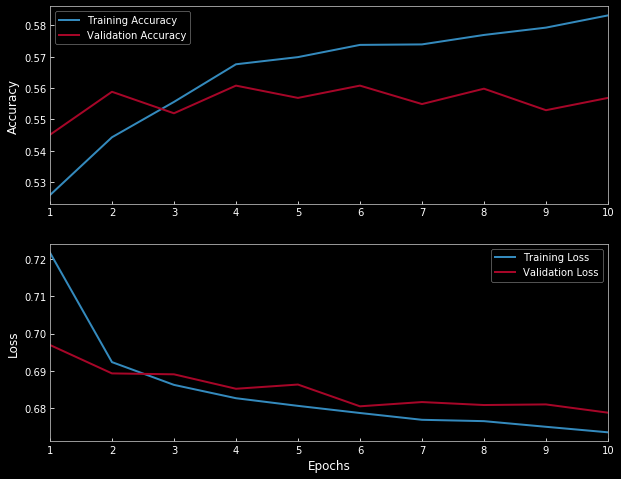

In [43]:
plot_training(results.history)

### Train Loop

In [6]:
model = model_initialise()

Model architecture created


In [8]:
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=3)

In [51]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = './tboard_logs/' + current_time + '/train'
valid_log_dir = './tboard_logs/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
valid_summary_writer = tf.summary.create_file_writer(valid_log_dir)

def _write_summary(epoch): 

    with train_summary_writer.as_default(): 
        tf.summary.scalar('Train Loss', train_loss.result(), step=epoch)
        tf.summary.scalar('Train Accuracy', train_accuracy.result(), step=epoch)
        
    with valid_summary_writer.as_default():
        tf.summary.scalar('Valid Loss', valid_loss.result(), step=epoch)
        tf.summary.scalar('Valid Accuracy', valid_accuracy.result(), step=epoch) 

In [52]:
min_loss = 100
results = defaultdict(list)

@tf.function
def training_graph(x, y, training):

    with tf.GradientTape() as tape:
        predictions = model(x, training=training)
        loss = loss_fn(y, predictions)

    if training:

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(
            zip(gradients, model.trainable_variables))

        train_loss(loss)
        train_accuracy(y, predictions)

    else:

        valid_loss(loss)
        valid_accuracy(y, predictions)

pb = tf.keras.utils.Progbar(train_len//batch_size, stateful_metrics='val_loss')

# Training-Validation process
for epoch in range(3):

    print("Epoch {}/{}".format(epoch+1,epochs))

    for i, (x, y) in enumerate(train):

        '''
        if self.augment:
            x = tf.squeeze(x)
            #x = tf.reshape(x[:,:,:], [x.shape[0]*x.shape[1]*x.shape[2], 200, 300, 3])
            x = tf.reshape(x, shape=[-1, 200, 300, self.batch_size])
            print(x.shape)
        '''
        training_graph(x, y, True)
        pb.update(i+1)

    for x, y in valid:
        training_graph(x, y, False)

    train_status_msg = "Training Loss: {:.3f}, Training Acc: {:.2f}% | Valid Loss: {:.3f}, Valid Acc: {:.2f}%"
    print(train_status_msg.format(train_loss.result(), train_accuracy.result()*100,
                                  valid_loss.result(), valid_accuracy.result()*100))

    if valid_loss.result() < min_loss:
        min_loss = valid_loss.result()
        save_path = manager.save()
        print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
        print("Loss {:1.2f}".format(min_loss))

    _write_summary(epoch)
        
    # Keep results for plotting
    results['loss'].append(train_loss.result().numpy())
    results['accuracy'].append(train_accuracy.result().numpy())
    results['val_loss'].append(valid_loss.result().numpy())
    results['val_accuracy'].append(valid_accuracy.result().numpy())
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    valid_loss.reset_states()
    valid_accuracy.reset_states()

Epoch 1/10
322/321 [==============================] - 15s 47ms/step
Training Loss: 0.760, Training Acc: 51.74% | Valid Loss: 0.701, Valid Acc: 53.94%
Saved checkpoint for step 1: ../../logs/tf_ckpts/ckpt-11
Loss 0.70
Epoch 2/10
322/321 [==============================] - 31s 96ms/step
Training Loss: 0.705, Training Acc: 54.85% | Valid Loss: 0.686, Valid Acc: 57.79%
Saved checkpoint for step 1: ../../logs/tf_ckpts/ckpt-12
Loss 0.69
Epoch 3/10
322/321 [==============================] - 46s 143ms/step
Training Loss: 0.693, Training Acc: 56.63% | Valid Loss: 0.684, Valid Acc: 58.84%
Saved checkpoint for step 1: ../../logs/tf_ckpts/ckpt-13
Loss 0.68


In [10]:
manager.checkpoints

['./tf_ckpts/ckpt-1', './tf_ckpts/ckpt-2', './tf_ckpts/ckpt-3']

In [ ]:
ckpt.restore(manager.checkpoints)

## Visualise Loss

In [ ]:
plot_training(results.history)

## Inference

In [9]:
from sklearn.metrics import confusion_matrix

In [10]:
def get_true_labels(dataset, dataset_len):

    true_y = []
    for _, y in dataset.take(dataset_len // batch_size ):
        true_y.append(np.argmax(y, axis=1))
    
    return np.concatenate(true_y)

In [11]:
preds = model.predict(test, steps=test_len // batch_size, use_multiprocessing = True)

In [12]:
test_y = get_true_labels(test, test_len)

In [13]:
confusion_matrix(test_y,np.argmax(preds,axis=1),labels=(0,1))

array([[326, 238],
       [265, 191]])